In [ ]:
##oxidation script
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def compute_derivative(i_segment, v_segment):
    di_dv = np.diff(i_segment) / np.diff(v_segment)
    v_mid = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid, di_dv

def moving_average(signal, window_size=5):
    pad = window_size // 2
    padded = np.pad(signal, pad_width=pad, mode='edge')
    kernel = np.ones(window_size) / window_size
    return np.convolve(padded, kernel, mode='valid')

def compute_second_derivative(v_segment, first_derivative):
    d2i_dv2 = np.diff(first_derivative) / np.diff(v_segment)
    v_mid2 = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid2, d2i_dv2

def find_local_minima(signal, num_minima=None):
    indices = argrelextrema(signal, np.less)[0]
    if num_minima is not None:
        sorted_idx = np.argsort(signal[indices])
        indices = indices[sorted_idx[:num_minima]]
    return np.sort(indices)

def find_local_maxima(signal, num_maxima=None):
    indices = argrelextrema(signal, np.greater)[0]
    if num_maxima is not None:
        sorted_idx = np.argsort(-signal[indices])
        indices = indices[sorted_idx[:num_maxima]]
    return np.sort(indices)

def remove_close_to_global_extrema(signal, v, indices, threshold_v=0.02):
    if len(indices) == 0:
        return indices
    global_min_idx = np.argmin(signal)
    global_max_idx = np.argmax(signal)
    filtered_indices = []
    for idx in indices:
        if abs(v[idx] - v[global_min_idx]) > threshold_v and abs(v[idx] - v[global_max_idx]) > threshold_v:
            filtered_indices.append(idx)
    return np.array(filtered_indices)

def select_minima_by_slope(v, signal, min_indices, max_indices, window_size=0.05):
    candidate_scores = []
    for idx in min_indices:
        v0 = v[idx]
        v_left_start = v0 - window_size
        v_left_end = v0
        v_right_start = v0
        v_right_end = v0 + window_size

        left_mask = (v >= v_left_start) & (v < v_left_end)
        right_mask = (v > v_right_start) & (v <= v_right_end)

        if np.sum(left_mask) < 2 or np.sum(right_mask) < 2:
            continue

        left_v = v[left_mask].astype(float)
        left_y = signal[left_mask].astype(float)
        right_v = v[right_mask].astype(float)
        right_y = signal[right_mask].astype(float)

        left_slope = np.polyfit(left_v, left_y, 1)[0]
        right_slope = np.polyfit(right_v, right_y, 1)[0]

        if left_slope < 0 and right_slope > 0:
            score = abs(left_slope) + abs(right_slope)
            candidate_scores.append((idx, score, left_slope, right_slope))

    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [x[0] for x in candidate_scores]
    return top_indices, candidate_scores

def process_and_plot_oxidation(folder_path, smooth_window=7, slope_window=0.05,
                               num_minima=5, num_maxima=5, threshold_close=0.02,
                               min_distance_between_minima=0.03):
    segments = [(0, 99), (100, 199), (200, 299), (300, 399)]
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    for filename in csv_files:
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path).dropna()
        voltage = data.iloc[:, -2].astype(float).values
        current = data.iloc[:, -1].astype(float).values

        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'File: {filename}', fontsize=14)

        oxidation_segments = [segments[i] for i in [3, 0]]
        v_combined = []
        i_combined = []
        for start, end in oxidation_segments:
            v_seg = voltage[start:end+1]
            i_seg = current[start:end+1]
            v_combined.append(v_seg)
            i_combined.append(i_seg)
        ox_v = np.concatenate(v_combined)
        ox_i = np.concatenate(i_combined)

        axs[0].plot(ox_v, ox_i, color='red', label='Oxidation')
        axs[0].set_xlabel('Voltage (V)')
        axs[0].set_ylabel('Current (A)')
        axs[0].set_title('Raw Oxidation I–V Curve')
        axs[0].legend()
        axs[0].grid(True)

        v_der1, deriv1 = compute_derivative(ox_i, ox_v)
        deriv1_smooth = moving_average(deriv1, window_size=smooth_window)

        v_der2, deriv2 = compute_second_derivative(v_der1, deriv1_smooth)
        deriv2_smooth = moving_average(deriv2, window_size=smooth_window)

        # Step 1: Get local extrema
        min_indices = find_local_minima(deriv2_smooth, num_minima)
        max_indices = find_local_maxima(deriv2_smooth, num_maxima)

        # Step 2: Remove those close to global min/max
        min_indices = remove_close_to_global_extrema(deriv2_smooth, v_der2, min_indices, threshold_v=threshold_close)

        # Step 3: Select best local minima based on slope
        best_minima, info = select_minima_by_slope(
            v_der2, deriv2_smooth, min_indices, max_indices, window_size=slope_window
        )

        # Step 4: Ensure two selected minima are not close
        final_selected = []
        if len(best_minima) > 0:
            final_selected.append(best_minima[0])
            for idx in best_minima[1:]:
                if abs(v_der2[idx] - v_der2[final_selected[0]]) >= min_distance_between_minima:
                    final_selected.append(idx)
                    break  # stop after finding a sufficiently distant second minimum

        # Plotting
        axs[1].plot(v_der2, deriv2_smooth, color='red', label='2nd Derivative Oxidation')
        colors = ['blue', 'green', 'purple', 'orange', 'brown']

        for i, idx in enumerate(final_selected):
            axs[1].plot(v_der2[idx], deriv2_smooth[idx], '*', color=colors[i % len(colors)], markersize=15,
                        label=f'Selected Min #{i+1} (Slope Δ={info[i][1]:.3f})')

        axs[1].set_xlabel('Voltage (V)')
        axs[1].set_ylabel('d²I/dV²')
        axs[1].set_title('2nd Derivative – Peak Slope Criteria')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# === USAGE ===
folder = 'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT/Smart Materials/Version 5/Q3/0.625mM/'
process_and_plot_oxidation(
    folder,
    smooth_window=17,
    slope_window=0.05,
    num_minima=100,
    num_maxima=0,
    threshold_close=0.02,
    min_distance_between_minima=0.3
)


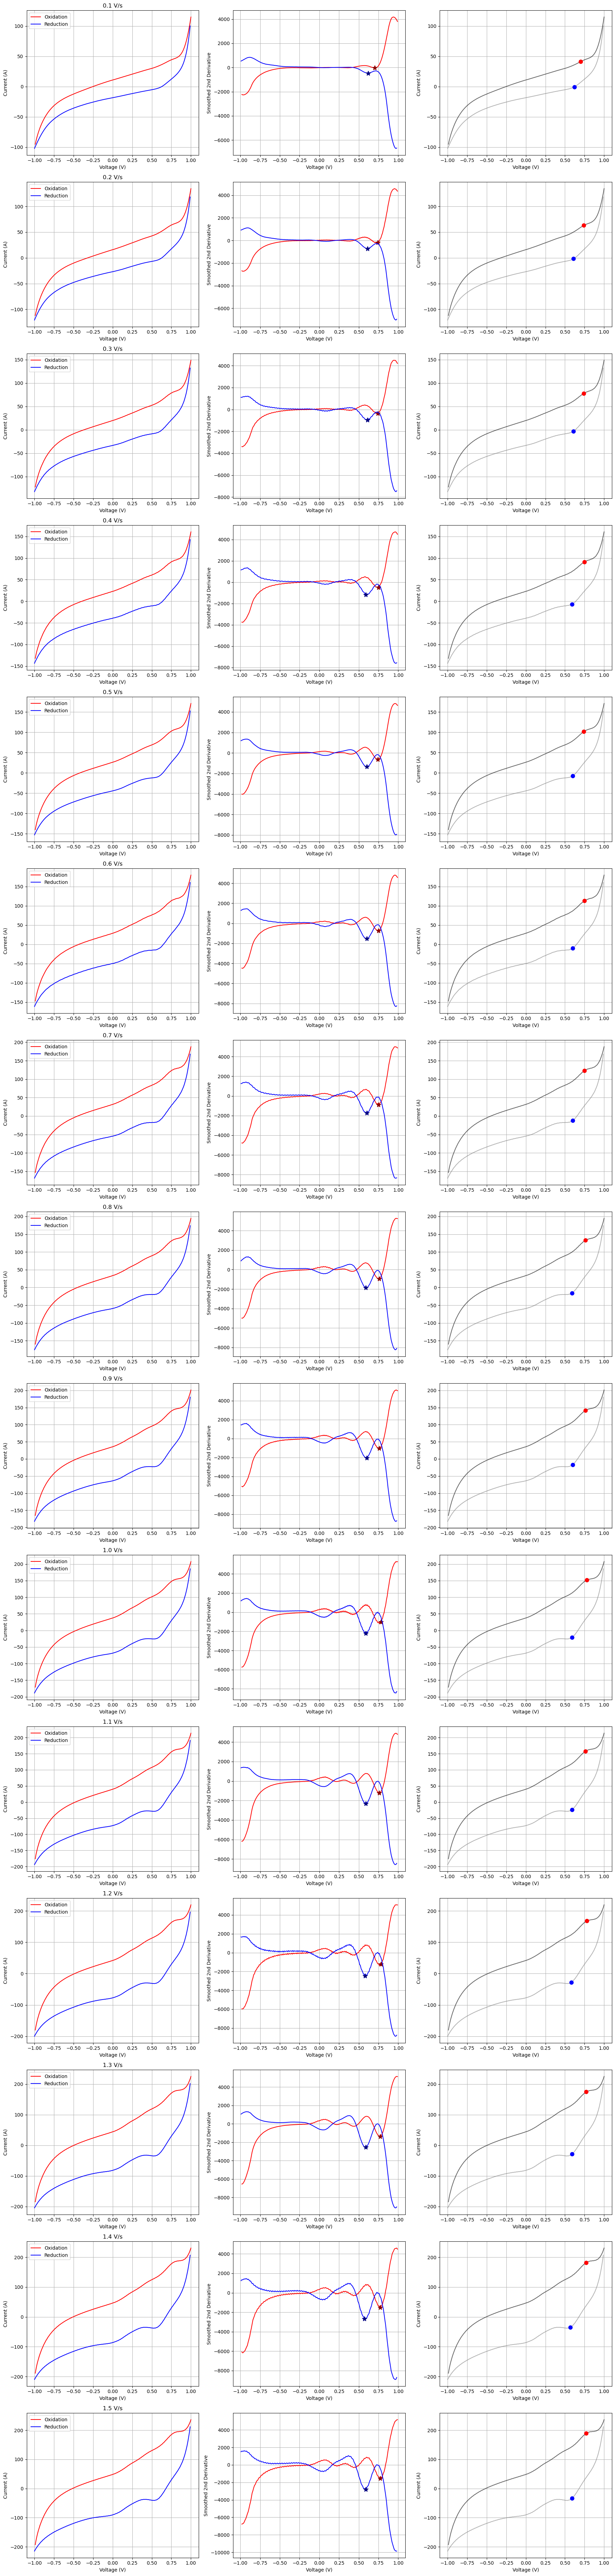


Detected Peak Values:
 Scan Rate (V/s)  Oxidation ip (A)  Reduction ip (A)
             0.1         41.175692         -0.528905
             0.2         63.074060         -1.811242
             0.3         77.992384         -3.000574
             0.4         91.360624         -6.920861
             0.5        101.487792         -7.309789
             0.6        113.409304         -9.745759
             0.7        123.179488        -12.322646
             0.8        132.789960        -15.917887
             0.9        141.479000        -16.729563
             1.0        152.001000        -21.265184
             1.1        157.365000        -23.425898
             1.2        167.943000        -28.258380
             1.3        174.717000        -28.718706
             1.4        181.894000        -35.069328
             1.5        189.062000        -33.857448

Estimated b (slope) for Oxidation: 0.6289
Estimated b (slope) for Reduction: 0.5911


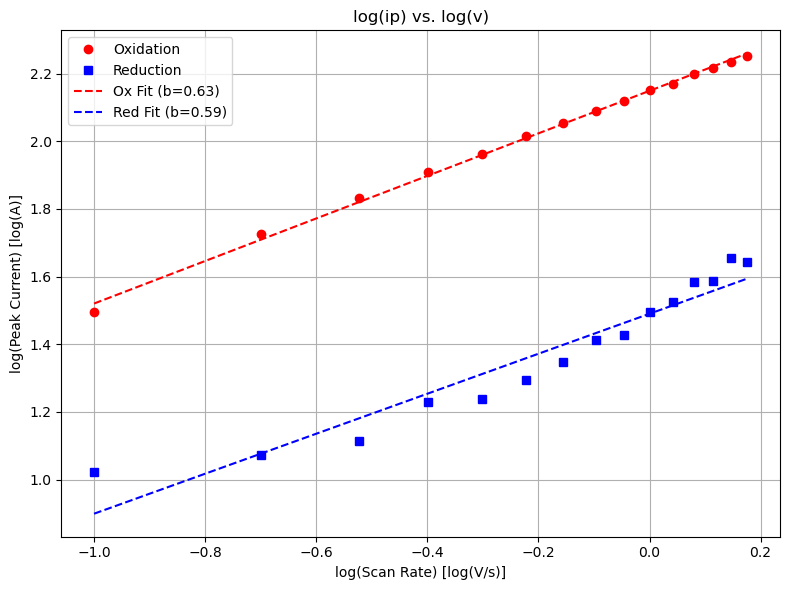

In [2]:
#### Peak detection script, single concentration (original without non faradic detection)
###This script is fixed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import math

# ===== Helper Functions =====
def compute_derivative(i_segment, v_segment):
    di_dv = np.diff(i_segment) / np.diff(v_segment)
    v_mid = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid, di_dv

def moving_average(signal, window_size=5):
    pad = window_size // 2
    padded = np.pad(signal, pad_width=pad, mode='edge')
    kernel = np.ones(window_size) / window_size
    return np.convolve(padded, kernel, mode='valid')

def compute_second_derivative(v_segment, first_derivative):
    d2i_dv2 = np.diff(first_derivative) / np.diff(v_segment)
    v_mid2 = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid2, d2i_dv2

def find_local_minima(signal, num_minima=None):
    indices = argrelextrema(signal, np.less)[0]
    if num_minima is not None:
        sorted_idx = np.argsort(signal[indices])
        indices = indices[sorted_idx[:num_minima]]
    return np.sort(indices)

def find_local_maxima(signal, num_maxima=None):
    indices = argrelextrema(signal, np.greater)[0]
    if num_maxima is not None:
        sorted_idx = np.argsort(-signal[indices])
        indices = indices[sorted_idx[:num_maxima]]
    return np.sort(indices)

def remove_close_to_global_extrema(signal, v, indices, threshold_v=0.02, threshold_signal=1e-8):
    if len(indices) == 0:
        return indices
    global_min_idx = np.argmin(signal)
    global_max_idx = np.argmax(signal)
    global_min_v = v[global_min_idx]
    global_max_v = v[global_max_idx]
    global_min_val = signal[global_min_idx]
    global_max_val = signal[global_max_idx]

    filtered_indices = []
    for idx in indices:
        is_close_v = (abs(v[idx] - global_min_v) <= threshold_v or abs(v[idx] - global_max_v) <= threshold_v)
        is_close_val = (abs(signal[idx] - global_min_val) < threshold_signal or abs(signal[idx] - global_max_val) < threshold_signal)
        if not (is_close_v or is_close_val):
            filtered_indices.append(idx)
    return np.array(filtered_indices)

def select_minima_by_slope(v, signal, min_indices, max_indices, window_size=0.05):
    candidate_scores = []
    for idx in min_indices:
        v0 = v[idx]
        v_left_start = v0 - window_size
        v_left_end = v0
        v_right_start = v0
        v_right_end = v0 + window_size

        left_mask = (v >= v_left_start) & (v < v_left_end)
        right_mask = (v > v_right_start) & (v <= v_right_end)

        if np.sum(left_mask) < 2 or np.sum(right_mask) < 2:
            continue

        left_v = v[left_mask].astype(float)
        left_y = signal[left_mask].astype(float)
        right_v = v[right_mask].astype(float)
        right_y = signal[right_mask].astype(float)

        left_slope = np.polyfit(left_v, left_y, 1)[0]
        right_slope = np.polyfit(right_v, right_y, 1)[0]

        if left_slope < 0 and right_slope > 0:
            score = abs(left_slope) + abs(right_slope)
            candidate_scores.append((idx, score, left_slope, right_slope))

    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [x[0] for x in candidate_scores]
    return top_indices, candidate_scores

def select_top_peaks_by_distance(v, candidate_indices, min_distance, num_peaks):
    selected = []
    for idx in candidate_indices:
        if not selected:
            selected.append(idx)
        else:
            if all(abs(v[idx] - v[s]) >= min_distance for s in selected):
                selected.append(idx)
        if len(selected) >= num_peaks:
            break
    return selected

# ===== Main Processing Function =====
def process_and_plot_combined(folder_path, smooth_window=7, slope_window=0.05,
                              num_minima=5, num_maxima=5, threshold_close=0.02,
                              min_distance_between_minima=0.03,
                              num_peaks_ox=2, num_peaks_red=2):

    log_v_list = []
    log_ip_ox_list = []
    log_ip_red_list = []
    peaks_data = []  # store results for table

    segments = [(0, 99), (100, 199), (200, 299), (300, 399)] ### Q3
#    segments = [(0, 109), (110, 210), (211, 317), (318, 399)] ### Q3
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files.sort()

    n_files = len(csv_files)
    fig, axs = plt.subplots(n_files, 3, figsize=(18, 5 * n_files))
    if n_files == 1:
        axs = np.expand_dims(axs, axis=0)

    for row_idx, filename in enumerate(csv_files):
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path).dropna()
        voltage = data.iloc[:, -2].astype(float).values
        current = data.iloc[:, -1].astype(float).values

        extracted_value = float(filename.split('_')[7])  # Scan rate

        ox_segments = [segments[i] for i in [3, 0]]
        ox_v = np.concatenate([voltage[start:end+1] for start, end in ox_segments])
        ox_i = np.concatenate([current[start:end+1] for start, end in ox_segments])

        red_segments = [segments[i] for i in [1, 2]]
        red_v = np.concatenate([voltage[start:end+1] for start, end in red_segments])
        red_i = np.concatenate([current[start:end+1] for start, end in red_segments])

        # ===== Oxidation =====
        ox_v_der1, ox_deriv1 = compute_derivative(ox_i, ox_v)
        ox_deriv1_smooth = moving_average(ox_deriv1, window_size=smooth_window)
        ox_v_der2, ox_deriv2 = compute_second_derivative(ox_v_der1, ox_deriv1_smooth)
        ox_deriv2_smooth = moving_average(ox_deriv2, window_size=smooth_window)

        ox_min_indices = find_local_minima(ox_deriv2_smooth, num_minima)
        ox_max_indices = find_local_maxima(ox_deriv2_smooth, num_maxima)
        ox_min_indices = remove_close_to_global_extrema(ox_deriv2_smooth, ox_v_der2, ox_min_indices, threshold_v=threshold_close)
        ox_best_minima, _ = select_minima_by_slope(ox_v_der2, ox_deriv2_smooth, ox_min_indices, ox_max_indices, window_size=slope_window)
        ox_final_selected = select_top_peaks_by_distance(ox_v_der2, ox_best_minima, min_distance_between_minima, num_peaks_ox)

        # ===== Reduction =====
        red_v_der1, red_deriv1 = compute_derivative(red_i, red_v)
        red_deriv1_smooth = moving_average(red_deriv1, window_size=smooth_window)
        red_v_der2, red_deriv2 = compute_second_derivative(red_v_der1, red_deriv1_smooth)
        red_deriv2_neg = -1 * red_deriv2
        red_deriv2_smooth = moving_average(red_deriv2_neg, window_size=smooth_window)

        red_min_indices = find_local_minima(red_deriv2_smooth, num_minima)
        red_max_indices = find_local_maxima(red_deriv2_smooth, num_maxima)
        red_min_indices = remove_close_to_global_extrema(red_deriv2_smooth, red_v_der2, red_min_indices, threshold_v=threshold_close)
        red_best_minima, _ = select_minima_by_slope(red_v_der2, red_deriv2_smooth, red_min_indices, red_max_indices, window_size=slope_window)
        red_final_selected = select_top_peaks_by_distance(red_v_der2, red_best_minima, min_distance_between_minima, num_peaks_red)

        # ===== Compute ip =====
        ox_ip = None
        red_ip = None
        ox_peak_v = None
        red_peak_v = None

        if ox_final_selected:
            # Pick index of the highest magnitude current but keep sign
            ox_peak_idx = ox_final_selected[np.argmax(
                [abs(ox_i[np.argmin(np.abs(ox_v - ox_v_der2[idx]))]) for idx in ox_final_selected]
            )]
            ox_peak_v = ox_v_der2[ox_peak_idx]
            ox_ip = ox_i[np.argmin(np.abs(ox_v - ox_v_der2[ox_peak_idx]))]  # no abs()

        if red_final_selected:
            red_peak_idx = red_final_selected[np.argmax(
                [abs(red_i[np.argmin(np.abs(red_v - red_v_der2[idx]))]) for idx in red_final_selected]
            )]
            red_peak_v = red_v_der2[red_peak_idx]
            red_ip = red_i[np.argmin(np.abs(red_v - red_v_der2[red_peak_idx]))]  # no abs()

        # Store peak data for table
        peaks_data.append({
        #    "File": filename,
            "Scan Rate (V/s)": extracted_value,
          #  "Oxidation V (V)": ox_peak_v,
            "Oxidation ip (A)": ox_ip,
         #   "Reduction V (V)": red_peak_v,
            "Reduction ip (A)": red_ip
        })

        # Store for log-log
        if ox_ip and red_ip and extracted_value > 0:
            log_v_list.append(math.log10(extracted_value))
            log_ip_ox_list.append(math.log10(abs(ox_ip-10)))
            log_ip_red_list.append(math.log10(abs(red_ip -10) ))

        # ===== Plot in subplot grid =====
        axs[row_idx, 0].plot(ox_v, ox_i, label='Oxidation', color='red')
        axs[row_idx, 0].plot(red_v, red_i, label='Reduction', color='blue')
        axs[row_idx, 0].set_xlabel('Voltage (V)')
        axs[row_idx, 0].set_ylabel('Current (A)')
        axs[row_idx, 0].set_title(f'{extracted_value} V/s')
        axs[row_idx, 0].legend()
        axs[row_idx, 0].grid(True)

        axs[row_idx, 1].plot(ox_v_der2, ox_deriv2_smooth, label='Oxidation', color='red')
        for idx in ox_final_selected:
            axs[row_idx, 1].plot(ox_v_der2[idx], ox_deriv2_smooth[idx], '*', color='darkred', markersize=10)
        axs[row_idx, 1].plot(red_v_der2, red_deriv2_smooth, label='Reduction', color='blue')
        for idx in red_final_selected:
            axs[row_idx, 1].plot(red_v_der2[idx], red_deriv2_smooth[idx], '*', color='navy', markersize=10)
        axs[row_idx, 1].set_xlabel('Voltage (V)')
        axs[row_idx, 1].set_ylabel('Smoothed 2nd Derivative')
        axs[row_idx, 1].grid(True)

        axs[row_idx, 2].plot(ox_v, ox_i, color='black', alpha=0.6)
        axs[row_idx, 2].plot(red_v, red_i, color='grey', alpha=0.6)
        for idx in ox_final_selected:
            raw_idx = np.argmin(np.abs(ox_v - ox_v_der2[idx]))
            axs[row_idx, 2].plot(ox_v[raw_idx], ox_i[raw_idx], 'o', color='red', markersize=8)
        for idx in red_final_selected:
            raw_idx = np.argmin(np.abs(red_v - red_v_der2[idx]))
            axs[row_idx, 2].plot(red_v[raw_idx], red_i[raw_idx], 'o', color='blue', markersize=8)
        axs[row_idx, 2].set_xlabel('Voltage (V)')
        axs[row_idx, 2].set_ylabel('Current (A)')
        axs[row_idx, 2].grid(True)

    plt.tight_layout()
    plt.show()

    # ===== Print final table =====
    peaks_df = pd.DataFrame(peaks_data)
    print("\nDetected Peak Values:")
    print(peaks_df.to_string(index=False))

    # ===== Final log-log plot =====
    if len(log_v_list) >= 2:
        ox_fit = np.polyfit(log_v_list, log_ip_ox_list, 1)
        red_fit = np.polyfit(log_v_list, log_ip_red_list, 1)
        b_ox = ox_fit[0]
        b_red = red_fit[0]
        print(f"\nEstimated b (slope) for Oxidation: {b_ox:.4f}")
        print(f"Estimated b (slope) for Reduction: {b_red:.4f}")

        x_fit = np.linspace(min(log_v_list), max(log_v_list), 100)
        y_fit_ox = np.polyval(ox_fit, x_fit)
        y_fit_red = np.polyval(red_fit, x_fit)

        plt.figure(figsize=(8, 6))
        plt.plot(log_v_list, log_ip_ox_list, 'o', color='red', label='Oxidation')
        plt.plot(log_v_list, log_ip_red_list, 's', color='blue', label='Reduction')
        plt.plot(x_fit, y_fit_ox, '--', color='red', label=f'Ox Fit (b={b_ox:.2f})')
        plt.plot(x_fit, y_fit_red, '--', color='blue', label=f'Red Fit (b={b_red:.2f})')
        plt.xlabel('log(Scan Rate) [log(V/s)]')
        plt.ylabel('log(Peak Current) [log(A)]')
        plt.title('log(ip) vs. log(v)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# ===== Usage Example =====
folder = 'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT/Smart Materials/Version 5/Q3/2.5mM/'
process_and_plot_combined(
    folder,
    smooth_window=13,
    slope_window=0.1,
    num_minima=100,
    num_maxima=100,
    threshold_close=0.06,
    min_distance_between_minima=0.05,
    num_peaks_ox=1,
    num_peaks_red=1
)


In [1]:
###This is the final version of the baseline correction script and peak vs scan rate analysis with interactive widgets
import os
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from scipy import stats # Added for slope calculation
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings

# Ignore common warnings for a cleaner output
warnings.filterwarnings('ignore')

def compute_derivative(i_segment, v_segment):
    """Computes the first derivative (dI/dV)."""
    di_dv = np.diff(i_segment) / np.diff(v_segment)
    v_mid = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid, di_dv

def moving_average(signal, window_size=5):
    """Applies a moving average filter to a signal."""
    if window_size < 1 or window_size % 2 == 0:
        window_size = max(1, window_size - (1 if window_size > 1 else 0)) # Ensure odd window size
    
    if window_size <= 1:
        return signal.copy()
        
    pad = window_size // 2
    padded = np.pad(signal, pad_width=pad, mode='edge')
    kernel = np.ones(window_size) / window_size
    return np.convolve(padded, kernel, mode='valid')

def compute_second_derivative(v_segment, first_derivative):
    """Computes the second derivative (d²I/dV²)."""
    d2i_dv2 = np.diff(first_derivative) / np.diff(v_segment)
    v_mid2 = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid2, d2i_dv2

def find_local_minima(signal, num_minima=None):
    """Finds local minima and returns the indices of the top N."""
    indices = argrelextrema(np.asarray(signal), np.less)[0]
    if num_minima is not None and len(indices) > 0:
        sorted_idx = np.argsort(signal[indices])
        indices = indices[sorted_idx[:num_minima]]
    return np.sort(indices)

def find_local_maxima(signal, num_maxima=None):
    """Finds local maxima and returns the indices of the top N."""
    indices = argrelextrema(np.asarray(signal), np.greater)[0]
    if num_maxima is not None and len(indices) > 0:
        sorted_idx = np.argsort(-signal[indices])
        indices = indices[sorted_idx[:num_maxima]]
    return np.sort(indices)

def remove_close_to_global_extrema(signal, v, indices, threshold_v=0.02, threshold_signal=1e-8):
    """Removes potential peaks that are too close to global extrema."""
    indices = np.array(indices, dtype=int)
    if indices.size == 0:
        return indices
    global_min_idx = np.argmin(signal)
    global_max_idx = np.argmax(signal)
    global_min_v = v[global_min_idx]
    global_max_v = v[global_max_idx]
    global_min_val = signal[global_min_idx]
    global_max_val = signal[global_max_idx]

    filtered_indices = []
    for idx in indices:
        is_close_v = (abs(v[idx] - global_min_v) <= threshold_v or abs(v[idx] - global_max_v) <= threshold_v)
        is_close_val = (abs(signal[idx] - global_min_val) < threshold_signal or abs(signal[idx] - global_max_val) < threshold_signal)
        if not (is_close_v or is_close_val):
            filtered_indices.append(idx)
    return np.array(filtered_indices, dtype=int)

def select_minima_by_slope(v, signal, min_indices, max_indices, window_size=0.05):
    """Selects the best minima based on the slope of the signal around the point."""
    candidate_scores = []
    for idx in min_indices:
        v0 = v[idx]
        v_left_start = v0 - window_size
        v_left_end = v0
        v_right_start = v0
        v_right_end = v0 + window_size

        left_mask = (v >= v_left_start) & (v < v_left_end)
        right_mask = (v > v_right_start) & (v <= v_right_end)

        if np.sum(left_mask) < 2 or np.sum(right_mask) < 2:
            continue

        left_v = v[left_mask].astype(float)
        left_y = signal[left_mask].astype(float)
        right_v = v[right_mask].astype(float)
        right_y = signal[right_mask].astype(float)

        left_slope = np.polyfit(left_v, left_y, 1)[0]
        right_slope = np.polyfit(right_v, right_y, 1)[0]

        if left_slope < 0 and right_slope > 0:
            score = abs(left_slope) + abs(right_slope)
            candidate_scores.append((idx, score, left_slope, right_slope))
    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [x[0] for x in candidate_scores]
    return top_indices, candidate_scores

def select_top_peaks_by_distance(v, candidate_indices, min_distance, num_peaks):
    """Selects the top peaks based on a minimum distance between them."""
    selected = []
    for idx in candidate_indices:
        if not selected:
            selected.append(idx)
        else:
            if all(abs(v[idx] - v[s]) >= min_distance for s in selected):
                selected.append(idx)
        if len(selected) >= num_peaks:
            break
    return selected

def find_side_points_raw(v_raw, i_raw, peak_raw_idx, window_length):
    """Finds the side points for baseline correction."""
    if peak_raw_idx is None or peak_raw_idx < 0 or peak_raw_idx >= len(v_raw):
        return None, None
    
    v0 = v_raw[peak_raw_idx]
    i0 = i_raw[peak_raw_idx]

    v_left = v0 - window_length / 2
    v_right = v0 + window_length / 2

    mask_left = (v_raw >= v_left) & (v_raw < v0)
    mask_right = (v_raw > v0) & (v_raw <= v_right)

    if not np.any(mask_left) or not np.any(mask_right):
        return None, None
    
    left_rel = np.argmax(np.abs(i_raw[mask_left] - i0))
    right_rel = np.argmax(np.abs(i_raw[mask_right] - i0))
    
    left_idx = np.where(mask_left)[0][left_rel]
    right_idx = np.where(mask_right)[0][right_rel]
    return left_idx, right_idx

def apply_baseline_correction(v_segment, i_segment, left_idx, right_idx):
    """Applies linear baseline correction."""
    if left_idx is None or right_idx is None:
        return i_segment.copy()
    corrected_i = i_segment.copy()
    
    x_left = v_segment[left_idx]
    x_right = v_segment[right_idx]
    y_left = i_segment[left_idx]
    y_right = i_segment[right_idx]
    
    if x_right == x_left:
        return corrected_i
    
    slope = (y_right - y_left) / (x_right - x_left)
    intercept = y_left - slope * x_left
    
    mask = (v_segment >= x_left) & (v_segment <= x_right)
    indices_to_replace = np.where(mask)[0]
    for idx in indices_to_replace:
        corrected_i[idx] = slope * v_segment[idx] + intercept
        
    return corrected_i

def analyze_file(file_path,
                 smooth_window=7, slope_window=0.05,
                 num_minima=5, num_maxima=5, threshold_close=0.02,
                 min_distance_between_minima=0.03,
                 num_peaks_ox=1, num_peaks_red=1,
                 window_length_ox=0.2, window_length_red=0.2):
    
    filename = os.path.basename(file_path)
    data = pd.read_csv(file_path).dropna()

    try:
        extracted_value = float(filename.split('_')[7])
    except Exception:
        extracted_value = 0.0

    cycle_columns = [
        {'voltage': 4, 'current': 5, 'cycle_label': 'Cycle 3'},
        {'voltage': 6, 'current': 7, 'cycle_label': 'Cycle 4'},
        {'voltage': 8, 'current': 9, 'cycle_label': 'Cycle 5'},
        {'voltage': 10, 'current': 11, 'cycle_label': 'Cycle 6'}
    ]

    results = []
    for cycle_info in cycle_columns:
        
        if cycle_info['voltage'] >= data.shape[1] or cycle_info['current'] >= data.shape[1]:
            continue

        voltage = data.iloc[:, cycle_info['voltage']].astype(float).values
        current = data.iloc[:, cycle_info['current']].astype(float).values

       # segments = [(0, 99), (100, 199), (200, 299), (300, 399)]
        segments = [(0, 109), (110, 210), (211, 317), (318, 399)] ### Q3
        ox_segments = [segments[i] for i in [3, 0]]
        ox_v = np.concatenate([voltage[start:end+1] for start, end in ox_segments])
        ox_i = np.concatenate([current[start:end+1] for start, end in ox_segments])

        red_segments = [segments[i] for i in [1, 2]]
        red_v = np.concatenate([voltage[start:end+1] for start, end in red_segments])
        red_i = np.concatenate([current[start:end+1] for start, end in red_segments])

        current_window_ox = window_length_ox + (extracted_value * 0.1)
        current_window_red = window_length_red + (extracted_value * 0.1)
        
        # ===== Oxidation processing =====
        ox_v_der1, ox_deriv1 = compute_derivative(ox_i, ox_v)
        ox_deriv1_smooth = moving_average(ox_deriv1, window_size=smooth_window)
        ox_v_der2, ox_deriv2 = compute_second_derivative(ox_v_der1, ox_deriv1_smooth)
        ox_deriv2_smooth = moving_average(ox_deriv2, window_size=smooth_window)
        
        ox_min_indices = find_local_minima(ox_deriv2_smooth, num_minima)
        ox_max_indices = find_local_maxima(ox_deriv2_smooth, num_maxima)
        ox_min_indices = remove_close_to_global_extrema(ox_deriv2_smooth, ox_v_der2, ox_min_indices, threshold_v=threshold_close)
        ox_best_minima, _ = select_minima_by_slope(ox_v_der2, ox_deriv2_smooth, ox_min_indices, None, window_size=slope_window)
        ox_final_selected = select_top_peaks_by_distance(ox_v_der2, ox_best_minima, min_distance_between_minima, num_peaks_ox)
        
        # ===== Reduction processing =====
        red_v_der1, red_deriv1 = compute_derivative(red_i, red_v)
        red_deriv1_smooth = moving_average(red_deriv1, window_size=smooth_window)
        red_v_der2, red_deriv2 = compute_second_derivative(red_v_der1, red_deriv1_smooth)
        red_deriv2_neg = -1 * red_deriv2
        red_deriv2_smooth = moving_average(red_deriv2_neg, window_size=smooth_window)

        red_min_indices = find_local_minima(red_deriv2_smooth, num_minima)
        red_max_indices = find_local_maxima(red_deriv2_smooth, num_maxima)
        red_min_indices = remove_close_to_global_extrema(red_deriv2_smooth, red_v_der2, red_min_indices, threshold_v=threshold_close)
        red_best_minima, _ = select_minima_by_slope(red_v_der2, red_deriv2_smooth, red_min_indices, None, window_size=slope_window)
        red_final_selected = select_top_peaks_by_distance(red_v_der2, red_best_minima, min_distance_between_minima, num_peaks_red)
        
        ox_raw_peak_idx = None
        red_raw_peak_idx = None
        ox_ip = None
        red_ip = None
        ox_side_raw = None
        red_side_raw = None

        if len(ox_final_selected) > 0:
            raw_idxs = [np.argmin(np.abs(ox_v - ox_v_der2[idx])) for idx in ox_final_selected]
            sel = np.argmax([abs(ox_i[r]) for r in raw_idxs])
            chosen_raw_idx = raw_idxs[sel]
            ox_raw_peak_idx = chosen_raw_idx
            ox_ip = ox_i[ox_raw_peak_idx]
            left_raw_idx, right_raw_idx = find_side_points_raw(ox_v, ox_i, ox_raw_peak_idx, current_window_ox)
            if left_raw_idx is not None and right_raw_idx is not None:
                ox_side_raw = (left_raw_idx, right_raw_idx)
                
        if len(red_final_selected) > 0:
            raw_idxs = [np.argmin(np.abs(red_v - red_v_der2[idx])) for idx in red_final_selected]
            sel = np.argmax([abs(red_i[r]) for r in raw_idxs])
            chosen_raw_idx = raw_idxs[sel]
            red_raw_peak_idx = chosen_raw_idx
            red_ip = red_i[red_raw_peak_idx]
            left_raw_idx, right_raw_idx = find_side_points_raw(red_v, red_i, red_raw_peak_idx, current_window_red)
            if left_raw_idx is not None and right_raw_idx is not None:
                red_side_raw = (left_raw_idx, right_raw_idx)
                
        ox_i_corrected = apply_baseline_correction(ox_v, ox_i,
                                                   ox_side_raw[0] if ox_side_raw else None,
                                                   ox_side_raw[1] if ox_side_raw else None)
        red_i_corrected = apply_baseline_correction(red_v, red_i,
                                                    red_side_raw[0] if red_side_raw else None,
                                                    red_side_raw[1] if red_side_raw else None)
        
        ox_i_subtracted = ox_i - ox_i_corrected
        red_i_subtracted = red_i - red_i_corrected
        
        ox_subtracted_peak = ox_i_subtracted[ox_raw_peak_idx] if ox_raw_peak_idx is not None else None
        red_subtracted_peak = red_i_subtracted[red_raw_peak_idx] if red_raw_peak_idx is not None else None
        
        results.append({
            "cycle_label": cycle_info['cycle_label'],
            "filename": filename,
            "scan_rate": extracted_value,
            "ox_v": ox_v, "ox_i": ox_i,
            "red_v": red_v, "red_i": red_i,
            "ox_i_corrected": ox_i_corrected,
            "red_i_corrected": red_i_corrected,
            "ox_i_subtracted": ox_i_subtracted,
            "red_i_subtracted": red_i_subtracted,
            "ox_raw_peak_idx": ox_raw_peak_idx,
            "red_raw_peak_idx": red_raw_peak_idx,
            "ox_ip": ox_ip, "red_ip": red_ip,
            "ox_v_der2": ox_v_der2, "ox_deriv2_smooth": ox_deriv2_smooth,
            "red_v_der2": red_v_der2, "red_deriv2_smooth": red_deriv2_smooth,
            "ox_final_selected": ox_final_selected,
            "red_final_selected": red_final_selected,
            "ox_subtracted_peak": ox_subtracted_peak,
            "red_subtracted_peak": red_subtracted_peak
        })

    return results

def create_interactive_plot(folder_path, selected_file_index=0, selected_cycle_index=0, **kwargs):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files.sort()

    if selected_file_index < 0 or selected_file_index >= len(csv_files):
        selected_file_index = 0

    file_path = os.path.join(folder_path, csv_files[selected_file_index])
    all_cycles_res = analyze_file(file_path, **kwargs)

    if not all_cycles_res:
        print("No cycles found for this file.")
        return None
        
    if selected_cycle_index < 0 or selected_cycle_index >= len(all_cycles_res):
        selected_cycle_index = 0

    res = all_cycles_res[selected_cycle_index]

    ox_v = res["ox_v"]; ox_i = res["ox_i"]
    red_v = res["red_v"]; red_i = res["red_i"]
    ox_i_corrected = res["ox_i_corrected"]; red_i_corrected = res["red_i_corrected"]
    ox_i_subtracted = res["ox_i_subtracted"]; red_i_subtracted = res["red_i_subtracted"]
    ox_raw_peak_idx = res["ox_raw_peak_idx"]; red_raw_peak_idx = res["red_raw_peak_idx"]
    ox_v_der2 = res["ox_v_der2"]; ox_deriv2_smooth = res["ox_deriv2_smooth"]
    red_v_der2 = res["red_v_der2"]; red_deriv2_smooth = res["red_deriv2_smooth"]
    ox_final_selected = res["ox_final_selected"]; red_final_selected = res["red_final_selected"]
    filename = res["filename"]; extracted_value = res["scan_rate"]
    cycle_label = res["cycle_label"]

    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Raw Data', 'Second Derivative', 'Peak Detection',
                        'Baseline Corrected', 'Subtracted Signal', 'Summary'),
        vertical_spacing=0.08,
        horizontal_spacing=0.08
    )

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i, mode='lines', name='Oxidation', line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=red_v, y=red_i, mode='lines', name='Reduction', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=ox_v_der2, y=ox_deriv2_smooth, mode='lines', name='Ox d2', line=dict(color='red')), row=1, col=2)
    fig.add_trace(go.Scatter(x=red_v_der2, y=red_deriv2_smooth, mode='lines', name='Red d2', line=dict(color='blue')), row=1, col=2)

    if ox_final_selected is not None and len(ox_final_selected) > 0:
        ox_peak_x = [ox_v_der2[idx] for idx in ox_final_selected]
        ox_peak_y = [ox_deriv2_smooth[idx] for idx in ox_final_selected]
        fig.add_trace(go.Scatter(x=ox_peak_x, y=ox_peak_y, mode='markers', name='Ox Peaks', marker=dict(color='darkred', size=8)), row=1, col=2)

    if red_final_selected is not None and len(red_final_selected) > 0:
        red_peak_x = [red_v_der2[idx] for idx in red_final_selected]
        red_peak_y = [red_deriv2_smooth[idx] for idx in red_final_selected]
        fig.add_trace(go.Scatter(x=red_peak_x, y=red_peak_y, mode='markers', name='Red Peaks', marker=dict(color='navy', size=8)), row=1, col=2)

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i, mode='lines', name='Ox raw', line=dict(color='black', width=1), showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=red_v, y=red_i, mode='lines', name='Red raw', line=dict(color='gray', width=1), showlegend=False), row=2, col=1)

    if ox_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[ox_v[ox_raw_peak_idx]], y=[ox_i[ox_raw_peak_idx]], mode='markers', name='Ox Peak', marker=dict(color='red', size=10)), row=2, col=1)
        left, right = find_side_points_raw(ox_v, ox_i, ox_raw_peak_idx, kwargs.get('window_length_ox', 0.2) + (extracted_value * 0.1))
        if left is not None and right is not None:
            fig.add_trace(go.Scatter(x=[ox_v[left], ox_v[right]], y=[ox_i[left], ox_i[right]], mode='lines+markers', name='Ox Baseline', line=dict(color='black', width=3), marker=dict(size=8)), row=2, col=1)

    if red_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[red_v[red_raw_peak_idx]], y=[red_i[red_raw_peak_idx]], mode='markers', name='Red Peak', marker=dict(color='blue', size=10)), row=2, col=1)
        left, right = find_side_points_raw(red_v, red_i, red_raw_peak_idx, kwargs.get('window_length_red', 0.2) + (extracted_value * 0.1))
        if left is not None and right is not None:
            fig.add_trace(go.Scatter(x=[red_v[left], red_v[right]], y=[red_i[left], red_i[right]], mode='lines+markers', name='Red Baseline', line=dict(color='black', width=3), marker=dict(size=8)), row=2, col=1)

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i_corrected, mode='lines', name='Ox Corrected', line=dict(color='red')), row=2, col=2)
    fig.add_trace(go.Scatter(x=red_v, y=red_i_corrected, mode='lines', name='Red Corrected', line=dict(color='blue')), row=2, col=2)
    fig.add_trace(go.Scatter(x=ox_v, y=ox_i_subtracted, mode='lines', name='Ox Subtracted', line=dict(color='red')), row=3, col=1)
    fig.add_trace(go.Scatter(x=red_v, y=red_i_subtracted, mode='lines', name='Red Subtracted', line=dict(color='blue')), row=3, col=1)

    if ox_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[ox_v[ox_raw_peak_idx]], y=[ox_i_subtracted[ox_raw_peak_idx]], mode='markers', name='Ox Sub Peak', marker=dict(color='darkred', size=10)), row=3, col=1)

    if red_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[red_v[red_raw_peak_idx]], y=[red_i_subtracted[red_raw_peak_idx]], mode='markers', name='Red Sub Peak', marker=dict(color='darkblue', size=10)), row=3, col=1)

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i, mode='lines', name='Original Ox', line=dict(color='red', dash='dash')), row=3, col=2)
    fig.add_trace(go.Scatter(x=ox_v, y=ox_i_subtracted, mode='lines', name='Subtracted Ox', line=dict(color='red')), row=3, col=2)
    fig.add_trace(go.Scatter(x=red_v, y=red_i, mode='lines', name='Original Red', line=dict(color='blue', dash='dash')), row=3, col=2)
    fig.add_trace(go.Scatter(x=red_v, y=red_i_subtracted, mode='lines', name='Subtracted Red', line=dict(color='blue')), row=3, col=2)

    fig.update_layout(width=1000, height=1200, showlegend=True, title_text=f"{filename} - {cycle_label} (Scan Rate: {extracted_value} V/s)")

    for r in range(1, 4):
        for c in range(1, 3):
            fig.update_xaxes(title_text="Voltage (V)", row=r, col=c)
            fig.update_yaxes(title_text="Current (uA)", row=r, col=c)
    
    return fig

def create_interactive_summary_plots(df):
    """Creates interactive Plotly graphs for average peaks vs scan rate and sqrt(scan rate)."""
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('All Peaks vs Scan Rate', 'All Peaks vs sqrt(Scan Rate)',
                        'Average Peaks vs Scan Rate', 'Average Peaks vs sqrt(Scan Rate)',
                        'Log(Ipeak) vs Log(Scan Rate)'),
        specs=[[{}, {}], [{}, {}], [{'colspan': 2}, None]],
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )

    avg_df = df.groupby('Scan Rate (V/s)').agg(
        {'Ox Subtracted Peak': 'mean', 'Red Subtracted Peak': 'mean'}
    ).reset_index()

    avg_df['sqrt(Scan Rate)'] = np.sqrt(avg_df['Scan Rate (V/s)'])
    df['sqrt(Scan Rate)'] = np.sqrt(df['Scan Rate (V/s)'])
    
    # Calculate log values
    epsilon = 1e-12 
    avg_df['log_scan_rate'] = np.log10(avg_df['Scan Rate (V/s)'])
    avg_df['log_ox_peak'] = np.log10(np.abs(avg_df['Ox Subtracted Peak']) + epsilon)
    avg_df['log_red_peak'] = np.log10(np.abs(avg_df['Red Subtracted Peak']) + epsilon)

    # --- New: Calculate slopes ---
    ox_slope, red_slope = np.nan, np.nan
    ox_label, red_label = "log(Avg Ox Peak)", "log(Avg Red Peak)"

    # Ensure there are enough points for a linear regression
    if len(avg_df) > 1:
        # Perform linear regression for oxidation peak
        ox_slope_res = stats.linregress(avg_df['log_scan_rate'], avg_df['log_ox_peak'])
        ox_slope = ox_slope_res.slope
        ox_label = f'log(Avg Ox Peak) | Slope: {ox_slope:.3f}'
        
        # Perform linear regression for reduction peak
        red_slope_res = stats.linregress(avg_df['log_scan_rate'], avg_df['log_red_peak'])
        red_slope = red_slope_res.slope
        red_label = f'log(Avg Red Peak) | Slope: {red_slope:.3f}'

    cycles = df['Cycle'].unique()
    markers = ['circle', 'square', 'diamond', 'cross', 'triangle-up', 'star-square']

    for i, cycle in enumerate(cycles):
        cycle_df = df[df['Cycle'] == cycle]
        fig.add_trace(go.Scatter(x=cycle_df["Scan Rate (V/s)"], y=cycle_df["Ox Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Ox', marker=dict(symbol=markers[i], color='darkred'), line=dict(color='red')), row=1, col=1)
        fig.add_trace(go.Scatter(x=cycle_df["Scan Rate (V/s)"], y=cycle_df["Red Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Red', marker=dict(symbol=markers[i], color='darkblue'), line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=cycle_df["sqrt(Scan Rate)"], y=cycle_df["Ox Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Ox', marker=dict(symbol=markers[i], color='darkred'), line=dict(color='red'), showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=cycle_df["sqrt(Scan Rate)"], y=cycle_df["Red Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Red', marker=dict(symbol=markers[i], color='darkblue'), line=dict(color='blue'), showlegend=False), row=1, col=2)

    fig.add_trace(go.Scatter(x=avg_df["Scan Rate (V/s)"], y=avg_df["Ox Subtracted Peak"], mode='lines+markers', name='Average Ox Peak', line=dict(color='red', dash='solid'), marker=dict(symbol='diamond', color='darkred', size=8)), row=2, col=1)
    fig.add_trace(go.Scatter(x=avg_df["Scan Rate (V/s)"], y=avg_df["Red Subtracted Peak"], mode='lines+markers', name='Average Red Peak', line=dict(color='blue', dash='solid'), marker=dict(symbol='diamond', color='darkblue', size=8)), row=2, col=1)
    fig.add_trace(go.Scatter(x=avg_df["sqrt(Scan Rate)"], y=avg_df["Ox Subtracted Peak"], mode='lines+markers', name='Average Ox Peak', line=dict(color='red', dash='solid'), marker=dict(symbol='diamond', color='darkred', size=8), showlegend=False), row=2, col=2)
    fig.add_trace(go.Scatter(x=avg_df["sqrt(Scan Rate)"], y=avg_df["Red Subtracted Peak"], mode='lines+markers', name='Average Red Peak', line=dict(color='blue', dash='solid'), marker=dict(symbol='diamond', color='darkblue', size=8), showlegend=False), row=2, col=2)

    # Add the log-log plot traces with the slope in the legend
    fig.add_trace(go.Scatter(x=avg_df["log_scan_rate"], y=avg_df["log_ox_peak"], mode='lines+markers', name=ox_label, line=dict(color='red', dash='dot'), marker=dict(symbol='star', color='darkred', size=8)), row=3, col=1)
    fig.add_trace(go.Scatter(x=avg_df["log_scan_rate"], y=avg_df["log_red_peak"], mode='lines+markers', name=red_label, line=dict(color='blue', dash='dot'), marker=dict(symbol='star', color='darkblue', size=8)), row=3, col=1)

    fig.update_layout(title_text="Peak Current Summary Across All Files", height=1200, showlegend=True)
    fig.update_xaxes(title_text="Scan Rate (V/s)", row=1, col=1); fig.update_yaxes(title_text="Peak Current (uA)", row=1, col=1)
    fig.update_xaxes(title_text= "√scan rate(V/s) ^(0.5)", row=1, col=2); fig.update_yaxes(title_text="Peak Current (uA)", row=1, col=2)
    fig.update_xaxes(title_text="Scan Rate (V/s)", row=2, col=1); fig.update_yaxes(title_text="Average Peak Current (uA)", row=2, col=1)
    fig.update_xaxes(title_text="√scan rate(V/s) ^(0.5)", row=2, col=2); fig.update_yaxes(title_text="Average Peak Current (uA)", row=2, col=2)
    fig.update_xaxes(title_text="log(Scan Rate)", row=3, col=1); fig.update_yaxes(title_text="log(|Peak Current|)", row=3, col=1)
    
    return fig

def create_interactive_interface(folder_path):
    """
    Creates the main user interface with widgets that update plots immediately on change.
    """
    try:
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        csv_files.sort()
    except FileNotFoundError:
        print(f"Error: The directory was not found: {folder_path}")
        return
    
    if not csv_files:
        print(f"No CSV files found in directory: {folder_path}")
        return

    # --- Data structure to store file-specific parameters ---
    fixed_params = {}

    # --- Define all the interactive widgets ---
    cycle_dropdown = widgets.Dropdown(options=[('Cycle 3', 0), ('Cycle 4', 1), ('Cycle 5', 2), ('Cycle 6', 3)], value=0, description='Cycle:')
    file_dropdown = widgets.Dropdown(options=[(f, i) for i, f in enumerate(csv_files)], value=0, description='File:')
    smooth_slider = widgets.IntSlider(value=11, min=3, max=21, step=2, description='Smooth Window:')
    slope_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Slope Window:')
    minima_slider = widgets.IntSlider(value=100, min=1, max=200, step=1, description='Num Minima:')
    maxima_slider = widgets.IntSlider(value=100, min=1, max=200, step=1, description='Num Maxima:')
    threshold_slider = widgets.FloatSlider(value=0.06, min=0.01, max=0.2, step=0.01, description='Threshold:')
    distance_slider = widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='Min Distance:')
    window_ox_slider = widgets.FloatSlider(value=0.6, min=0.1, max=0.6, step=0.01, description='Window Ox:')
    window_red_slider = widgets.FloatSlider(value=1, min=0.1, max=1, step=0.01, description='Window Red:')
    
    # --- Capture the initial default parameters from the widgets ---
    initial_default_params = {
        'smooth_window': smooth_slider.value,
        'slope_window': slope_slider.value,
        'num_minima': minima_slider.value,
        'num_maxima': maxima_slider.value,
        'threshold_close': threshold_slider.value,
        'min_distance_between_minima': distance_slider.value,
        'num_peaks_ox': 1,
        'num_peaks_red': 1,
        'window_length_ox': window_ox_slider.value,
        'window_length_red': window_red_slider.value
    }

    # --- Define Buttons ---
    print_button = widgets.Button(description="Generate Summary", button_style='info')
    fix_button = widgets.Button(description="Fix Parameter", button_style='success', icon='thumb-tack')

    # --- Define output areas for the plots and data ---
    output_single = widgets.Output()
    output_summary = widgets.Output()
    output_feedback = widgets.Output() 

    # --- Plotting function (triggered by widget changes) ---
    def update_plots(change=None):
        file_idx = file_dropdown.value
        
        # Determine parameters for analysis: use fixed if they exist, else use current slider values
        params_for_analysis = fixed_params.get(file_idx)
        if params_for_analysis is None:
            params_for_analysis = {
                'smooth_window': smooth_slider.value,
                'slope_window': slope_slider.value,
                'num_minima': minima_slider.value,
                'num_maxima': maxima_slider.value,
                'threshold_close': threshold_slider.value,
                'min_distance_between_minima': distance_slider.value,
                'window_length_ox': window_ox_slider.value,
                'window_length_red': window_red_slider.value
            }

        with output_single:
            clear_output(wait=True)
            fig = create_interactive_plot(
                folder_path=folder_path,
                selected_file_index=file_idx,
                selected_cycle_index=cycle_dropdown.value,
                num_peaks_ox=1,
                num_peaks_red=1,
                **params_for_analysis
            )
            if fig is not None:
                fig.show()

    # --- Function to sync sliders and update plot when the file changes ---
    def sync_sliders_and_update(change=None):
        file_idx = file_dropdown.value
        
        # **CORE LOGIC FIX:** Get this file's fixed params, or fall back to the initial defaults
        params_to_display = fixed_params.get(file_idx, initial_default_params)

        # Temporarily disable observers to prevent feedback loops while we set values
        for w in slider_widgets:
            w.unobserve(update_plots, names='value')

        # Set all sliders to the determined values
        smooth_slider.value = params_to_display['smooth_window']
        slope_slider.value = params_to_display['slope_window']
        minima_slider.value = params_to_display['num_minima']
        maxima_slider.value = params_to_display['num_maxima']
        threshold_slider.value = params_to_display['threshold_close']
        distance_slider.value = params_to_display['min_distance_between_minima']
        window_ox_slider.value = params_to_display['window_length_ox']
        window_red_slider.value = params_to_display['window_length_red']
        
        # Re-enable observers
        for w in slider_widgets:
            w.observe(update_plots, names='value')
        
        # Trigger a single plot update now that the sliders are correct
        update_plots()

    # --- Function to fix parameters for the current file ---
    def fix_parameters_on_click(b):
        file_idx = file_dropdown.value
        filename = csv_files[file_idx]
        
        current_params = {
            'smooth_window': smooth_slider.value, 'slope_window': slope_slider.value,
            'num_minima': minima_slider.value, 'num_maxima': maxima_slider.value,
            'threshold_close': threshold_slider.value, 'min_distance_between_minima': distance_slider.value,
            'window_length_ox': window_ox_slider.value, 'window_length_red': window_red_slider.value
        }
        
        fixed_params[file_idx] = current_params
        with output_feedback:
            clear_output(wait=True)
            print(f"✅ Parameters have been fixed for: {filename}")
        update_plots()

    # --- Data summary function (triggered by button click) ---
    def print_peaks_on_click(b):
        with output_summary:
            clear_output(wait=True)
            print("Collecting data from all files... Please wait.")
            
            all_res = []
            for i, f in enumerate(csv_files):
                file_path = os.path.join(folder_path, f)
                # Use fixed params if they exist, otherwise use the INITIAL DEFAULTS.
                params_for_file = fixed_params.get(i, initial_default_params)
                res = analyze_file(file_path, **params_for_file)
                all_res.extend(res)
            
            summary_data = []
            for res in all_res:
                summary_data.append({
                    "File": res["filename"], "Cycle": res["cycle_label"],
                    "Scan Rate (V/s)": res["scan_rate"],
                    "Ox Subtracted Peak": res["ox_subtracted_peak"],
                    "Red Subtracted Peak": res["red_subtracted_peak"]
                })
            df = pd.DataFrame(summary_data)
            clear_output(wait=True)
           # display(df)
            
            summary_fig = create_interactive_summary_plots(df)
            summary_fig.show()
    
    # --- Attach the event handlers ---
    file_dropdown.observe(sync_sliders_and_update, names='value')
    cycle_dropdown.observe(update_plots, names='value')
    
    slider_widgets = [
        smooth_slider, slope_slider, minima_slider, maxima_slider, 
        threshold_slider, distance_slider, window_ox_slider, window_red_slider
    ]
    for widget in slider_widgets:
        widget.observe(update_plots, names='value')

    print_button.on_click(print_peaks_on_click)
    fix_button.on_click(fix_parameters_on_click)
    
    # --- Assemble the UI layout ---
    controls_left = widgets.VBox([file_dropdown, cycle_dropdown, smooth_slider, slope_slider, minima_slider])
    controls_right = widgets.VBox([maxima_slider, threshold_slider, distance_slider, window_ox_slider, window_red_slider])
    buttons = widgets.HBox([print_button, fix_button])
    controls = widgets.VBox([widgets.HBox([controls_left, controls_right]), buttons, output_feedback])

    tab_single = widgets.VBox([widgets.Label("Single File Analysis:"), output_single])
    tab_summary = widgets.VBox([widgets.Label("All Files Peaks Summary:"), output_summary])
    tabs = widgets.Tab(children=[tab_single, tab_summary])
    tabs.set_title(0, 'Single File Analysis')
    tabs.set_title(1, 'Full Data Summary')
    
    display(controls)
    display(tabs)
    
    update_plots()

# --- Example Usage ---C:\Users\halhajali\OneDrive - Fondazione Istituto Italiano Tecnologia\Desktop\IIT\Smart Materials\Version 6\Q5 CuPd PCM Test
# Make sure to replace this path with the actual path to your folder
folder = 'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT/Smart Materials/Version 7/Q5_PCM+GLU/5mM/'
create_interactive_interface(folder)

In [ ]:
### This is the final version of the baseline correction script and peak vs scan rate analysis with interactive widgets
import os
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from scipy import stats # Added for slope calculation
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings

# Ignore common warnings for a cleaner output
warnings.filterwarnings('ignore')

def compute_derivative(i_segment, v_segment):
    """Computes the first derivative (dI/dV)."""
    di_dv = np.diff(i_segment) / np.diff(v_segment)
    v_mid = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid, di_dv

def moving_average(signal, window_size=5):
    """Applies a moving average filter to a signal."""
    if window_size < 1 or window_size % 2 == 0:
        window_size = max(1, window_size - (1 if window_size > 1 else 0)) # Ensure odd window size
    
    if window_size <= 1:
        return signal.copy()
        
    pad = window_size // 2
    padded = np.pad(signal, pad_width=pad, mode='edge')
    kernel = np.ones(window_size) / window_size
    return np.convolve(padded, kernel, mode='valid')

def compute_second_derivative(v_segment, first_derivative):
    """Computes the second derivative (d²I/dV²)."""
    d2i_dv2 = np.diff(first_derivative) / np.diff(v_segment)
    v_mid2 = (v_segment[:-1] + v_segment[1:]) / 2
    return v_mid2, d2i_dv2

def find_local_minima(signal, num_minima=None):
    """Finds local minima and returns the indices of the top N."""
    indices = argrelextrema(np.asarray(signal), np.less)[0]
    if num_minima is not None and len(indices) > 0:
        sorted_idx = np.argsort(signal[indices])
        indices = indices[sorted_idx[:num_minima]]
    return np.sort(indices)

def find_local_maxima(signal, num_maxima=None):
    """Finds local maxima and returns the indices of the top N."""
    indices = argrelextrema(np.asarray(signal), np.greater)[0]
    if num_maxima is not None and len(indices) > 0:
        sorted_idx = np.argsort(-signal[indices])
        indices = indices[sorted_idx[:num_maxima]]
    return np.sort(indices)

def remove_close_to_global_extrema(signal, v, indices, threshold_v=0.02, threshold_signal=1e-8):
    """Removes potential peaks that are too close to global extrema."""
    indices = np.array(indices, dtype=int)
    if indices.size == 0:
        return indices
    global_min_idx = np.argmin(signal)
    global_max_idx = np.argmax(signal)
    global_min_v = v[global_min_idx]
    global_max_v = v[global_max_idx]
    global_min_val = signal[global_min_idx]
    global_max_val = signal[global_max_idx]

    filtered_indices = []
    for idx in indices:
        is_close_v = (abs(v[idx] - global_min_v) <= threshold_v or abs(v[idx] - global_max_v) <= threshold_v)
        is_close_val = (abs(signal[idx] - global_min_val) < threshold_signal or abs(signal[idx] - global_max_val) < threshold_signal)
        if not (is_close_v or is_close_val):
            filtered_indices.append(idx)
    return np.array(filtered_indices, dtype=int)

def select_minima_by_slope(v, signal, min_indices, max_indices, window_size=0.05):
    """Selects the best minima based on the slope of the signal around the point."""
    candidate_scores = []
    for idx in min_indices:
        v0 = v[idx]
        v_left_start = v0 - window_size
        v_left_end = v0
        v_right_start = v0
        v_right_end = v0 + window_size

        left_mask = (v >= v_left_start) & (v < v_left_end)
        right_mask = (v > v_right_start) & (v <= v_right_end)

        if np.sum(left_mask) < 2 or np.sum(right_mask) < 2:
            continue

        left_v = v[left_mask].astype(float)
        left_y = signal[left_mask].astype(float)
        right_v = v[right_mask].astype(float)
        right_y = signal[right_mask].astype(float)

        left_slope = np.polyfit(left_v, left_y, 1)[0]
        right_slope = np.polyfit(right_v, right_y, 1)[0]

        if left_slope < 0 and right_slope > 0:
            score = abs(left_slope) + abs(right_slope)
            candidate_scores.append((idx, score, left_slope, right_slope))
    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [x[0] for x in candidate_scores]
    return top_indices, candidate_scores

def select_top_peaks_by_distance(v, candidate_indices, min_distance, num_peaks):
    """Selects the top peaks based on a minimum distance between them."""
    selected = []
    for idx in candidate_indices:
        if not selected:
            selected.append(idx)
        else:
            if all(abs(v[idx] - v[s]) >= min_distance for s in selected):
                selected.append(idx)
        if len(selected) >= num_peaks:
            break
    return selected

def find_side_points_raw(v_raw, i_raw, peak_raw_idx, window_length):
    """Finds the side points for baseline correction."""
    if peak_raw_idx is None or peak_raw_idx < 0 or peak_raw_idx >= len(v_raw):
        return None, None
    
    v0 = v_raw[peak_raw_idx]
    i0 = i_raw[peak_raw_idx]

    v_left = v0 - window_length / 2
    v_right = v0 + window_length / 2

    mask_left = (v_raw >= v_left) & (v_raw < v0)
    mask_right = (v_raw > v0) & (v_raw <= v_right)

    if not np.any(mask_left) or not np.any(mask_right):
        return None, None
    
    left_rel = np.argmax(np.abs(i_raw[mask_left] - i0))
    right_rel = np.argmax(np.abs(i_raw[mask_right] - i0))
    
    left_idx = np.where(mask_left)[0][left_rel]
    right_idx = np.where(mask_right)[0][right_rel]
    return left_idx, right_idx

def apply_baseline_correction(v_segment, i_segment, left_idx, right_idx):
    """Applies linear baseline correction."""
    if left_idx is None or right_idx is None:
        return i_segment.copy()
    corrected_i = i_segment.copy()
    
    x_left = v_segment[left_idx]
    x_right = v_segment[right_idx]
    y_left = i_segment[left_idx]
    y_right = i_segment[right_idx]
    
    if x_right == x_left:
        return corrected_i
    
    slope = (y_right - y_left) / (x_right - x_left)
    intercept = y_left - slope * x_left
    
    mask = (v_segment >= x_left) & (v_segment <= x_right)
    indices_to_replace = np.where(mask)[0]
    for idx in indices_to_replace:
        corrected_i[idx] = slope * v_segment[idx] + intercept
        
    return corrected_i

def analyze_file(file_path,
                 smooth_window=7, slope_window=0.05,
                 num_minima=5, num_maxima=5, threshold_close=0.02,
                 min_distance_between_minima=0.03,
                 num_peaks_ox=1, num_peaks_red=1,
                 window_length_ox=0.2, window_length_red=0.2):
    
    filename = os.path.basename(file_path)
    # New code
    data = pd.read_csv(file_path, engine='python').dropna()

    try:
        extracted_value = float(filename.split('_')[7])
    except Exception:
        extracted_value = 0.0

    # MODIFICATION: Only use Cycle 6
    cycle_columns = [
        {'voltage': 10, 'current': 11, 'cycle_label': 'Cycle 6'}
    ]

    results = []
    for cycle_info in cycle_columns:
        
        if cycle_info['voltage'] >= data.shape[1] or cycle_info['current'] >= data.shape[1]:
            continue

        voltage = data.iloc[:, cycle_info['voltage']].astype(float).values
        current = data.iloc[:, cycle_info['current']].astype(float).values

        segments = [(0, 109), (110, 210), (211, 317), (318, 399)] ### Q3
        ox_segments = [segments[i] for i in [3, 0]]
        ox_v = np.concatenate([voltage[start:end+1] for start, end in ox_segments])
        ox_i = np.concatenate([current[start:end+1] for start, end in ox_segments])

        red_segments = [segments[i] for i in [1, 2]]
        red_v = np.concatenate([voltage[start:end+1] for start, end in red_segments])
        red_i = np.concatenate([current[start:end+1] for start, end in red_segments])

        current_window_ox = window_length_ox + (extracted_value * 0.1)
        current_window_red = window_length_red + (extracted_value * 0.1)
        
        # ===== Oxidation processing =====
        ox_v_der1, ox_deriv1 = compute_derivative(ox_i, ox_v)
        ox_deriv1_smooth = moving_average(ox_deriv1, window_size=smooth_window)
        ox_v_der2, ox_deriv2 = compute_second_derivative(ox_v_der1, ox_deriv1_smooth)
        ox_deriv2_smooth = moving_average(ox_deriv2, window_size=smooth_window)
        
        ox_min_indices = find_local_minima(ox_deriv2_smooth, num_minima)
        ox_max_indices = find_local_maxima(ox_deriv2_smooth, num_maxima)
        ox_min_indices = remove_close_to_global_extrema(ox_deriv2_smooth, ox_v_der2, ox_min_indices, threshold_v=threshold_close)
        ox_best_minima, _ = select_minima_by_slope(ox_v_der2, ox_deriv2_smooth, ox_min_indices, None, window_size=slope_window)
        ox_final_selected = select_top_peaks_by_distance(ox_v_der2, ox_best_minima, min_distance_between_minima, num_peaks_ox)
        
        # ===== Reduction processing =====
        red_v_der1, red_deriv1 = compute_derivative(red_i, red_v)
        red_deriv1_smooth = moving_average(red_deriv1, window_size=smooth_window)
        red_v_der2, red_deriv2 = compute_second_derivative(red_v_der1, red_deriv1_smooth)
        red_deriv2_neg = -1 * red_deriv2
        red_deriv2_smooth = moving_average(red_deriv2_neg, window_size=smooth_window)

        red_min_indices = find_local_minima(red_deriv2_smooth, num_minima)
        red_max_indices = find_local_maxima(red_deriv2_smooth, num_maxima)
        red_min_indices = remove_close_to_global_extrema(red_deriv2_smooth, red_v_der2, red_min_indices, threshold_v=threshold_close)
        red_best_minima, _ = select_minima_by_slope(red_v_der2, red_deriv2_smooth, red_min_indices, None, window_size=slope_window)
        red_final_selected = select_top_peaks_by_distance(red_v_der2, red_best_minima, min_distance_between_minima, num_peaks_red)
        
        ox_raw_peak_idx = None
        red_raw_peak_idx = None
        ox_ip = None
        red_ip = None
        ox_side_raw = None
        red_side_raw = None

        if len(ox_final_selected) > 0:
            raw_idxs = [np.argmin(np.abs(ox_v - ox_v_der2[idx])) for idx in ox_final_selected]
            sel = np.argmax([abs(ox_i[r]) for r in raw_idxs])
            chosen_raw_idx = raw_idxs[sel]
            ox_raw_peak_idx = chosen_raw_idx
            ox_ip = ox_i[ox_raw_peak_idx]
            left_raw_idx, right_raw_idx = find_side_points_raw(ox_v, ox_i, ox_raw_peak_idx, current_window_ox)
            if left_raw_idx is not None and right_raw_idx is not None:
                ox_side_raw = (left_raw_idx, right_raw_idx)
                
        if len(red_final_selected) > 0:
            raw_idxs = [np.argmin(np.abs(red_v - red_v_der2[idx])) for idx in red_final_selected]
            sel = np.argmax([abs(red_i[r]) for r in raw_idxs])
            chosen_raw_idx = raw_idxs[sel]
            red_raw_peak_idx = chosen_raw_idx
            red_ip = red_i[red_raw_peak_idx]
            left_raw_idx, right_raw_idx = find_side_points_raw(red_v, red_i, red_raw_peak_idx, current_window_red)
            if left_raw_idx is not None and right_raw_idx is not None:
                red_side_raw = (left_raw_idx, right_raw_idx)
                
        ox_i_corrected = apply_baseline_correction(ox_v, ox_i,
                                                 ox_side_raw[0] if ox_side_raw else None,
                                                 ox_side_raw[1] if ox_side_raw else None)
        red_i_corrected = apply_baseline_correction(red_v, red_i,
                                                  red_side_raw[0] if red_side_raw else None,
                                                  red_side_raw[1] if red_side_raw else None)
        
        ox_i_subtracted = ox_i - ox_i_corrected
        red_i_subtracted = red_i - red_i_corrected
        
        ox_subtracted_peak = ox_i_subtracted[ox_raw_peak_idx] if ox_raw_peak_idx is not None else None
        red_subtracted_peak = red_i_subtracted[red_raw_peak_idx] if red_raw_peak_idx is not None else None
        
        results.append({
            "cycle_label": cycle_info['cycle_label'],
            "filename": filename,
            "scan_rate": extracted_value,
            "ox_v": ox_v, "ox_i": ox_i,
            "red_v": red_v, "red_i": red_i,
            "ox_i_corrected": ox_i_corrected,
            "red_i_corrected": red_i_corrected,
            "ox_i_subtracted": ox_i_subtracted,
            "red_i_subtracted": red_i_subtracted,
            "ox_raw_peak_idx": ox_raw_peak_idx,
            "red_raw_peak_idx": red_raw_peak_idx,
            "ox_ip": ox_ip, "red_ip": red_ip,
            "ox_v_der2": ox_v_der2, "ox_deriv2_smooth": ox_deriv2_smooth,
            "red_v_der2": red_v_der2, "red_deriv2_smooth": red_deriv2_smooth,
            "ox_final_selected": ox_final_selected,
            "red_final_selected": red_final_selected,
            "ox_subtracted_peak": ox_subtracted_peak,
            "red_subtracted_peak": red_subtracted_peak
        })

    return results

def create_interactive_plot(folder_path, selected_file_index=0, selected_cycle_index=0, **kwargs):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files.sort()

    if selected_file_index < 0 or selected_file_index >= len(csv_files):
        selected_file_index = 0

    file_path = os.path.join(folder_path, csv_files[selected_file_index])
    all_cycles_res = analyze_file(file_path, **kwargs)

    if not all_cycles_res:
        print("No cycles found for this file.")
        return None
        
    if selected_cycle_index < 0 or selected_cycle_index >= len(all_cycles_res):
        selected_cycle_index = 0

    res = all_cycles_res[selected_cycle_index]

    ox_v = res["ox_v"]; ox_i = res["ox_i"]
    red_v = res["red_v"]; red_i = res["red_i"]
    ox_i_corrected = res["ox_i_corrected"]; red_i_corrected = res["red_i_corrected"]
    ox_i_subtracted = res["ox_i_subtracted"]; red_i_subtracted = res["red_i_subtracted"]
    ox_raw_peak_idx = res["ox_raw_peak_idx"]; red_raw_peak_idx = res["red_raw_peak_idx"]
    ox_v_der2 = res["ox_v_der2"]; ox_deriv2_smooth = res["ox_deriv2_smooth"]
    red_v_der2 = res["red_v_der2"]; red_deriv2_smooth = res["red_deriv2_smooth"]
    ox_final_selected = res["ox_final_selected"]; red_final_selected = res["red_final_selected"]
    filename = res["filename"]; extracted_value = res["scan_rate"]
    cycle_label = res["cycle_label"]

    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Raw Data', 'Second Derivative', 'Peak Detection',
                        'Baseline Corrected', 'Subtracted Signal', 'Summary'),
        vertical_spacing=0.08,
        horizontal_spacing=0.08
    )

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i, mode='lines', name='Oxidation', line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=red_v, y=red_i, mode='lines', name='Reduction', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=ox_v_der2, y=ox_deriv2_smooth, mode='lines', name='Ox d2', line=dict(color='red')), row=1, col=2)
    fig.add_trace(go.Scatter(x=red_v_der2, y=red_deriv2_smooth, mode='lines', name='Red d2', line=dict(color='blue')), row=1, col=2)

    if ox_final_selected is not None and len(ox_final_selected) > 0:
        ox_peak_x = [ox_v_der2[idx] for idx in ox_final_selected]
        ox_peak_y = [ox_deriv2_smooth[idx] for idx in ox_final_selected]
        fig.add_trace(go.Scatter(x=ox_peak_x, y=ox_peak_y, mode='markers', name='Ox Peaks', marker=dict(color='darkred', size=8)), row=1, col=2)

    if red_final_selected is not None and len(red_final_selected) > 0:
        red_peak_x = [red_v_der2[idx] for idx in red_final_selected]
        red_peak_y = [red_deriv2_smooth[idx] for idx in red_final_selected]
        fig.add_trace(go.Scatter(x=red_peak_x, y=red_peak_y, mode='markers', name='Red Peaks', marker=dict(color='navy', size=8)), row=1, col=2)

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i, mode='lines', name='Ox raw', line=dict(color='black', width=1), showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=red_v, y=red_i, mode='lines', name='Red raw', line=dict(color='gray', width=1), showlegend=False), row=2, col=1)

    if ox_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[ox_v[ox_raw_peak_idx]], y=[ox_i[ox_raw_peak_idx]], mode='markers', name='Ox Peak', marker=dict(color='red', size=10)), row=2, col=1)
        left, right = find_side_points_raw(ox_v, ox_i, ox_raw_peak_idx, kwargs.get('window_length_ox', 0.2) + (extracted_value * 0.1))
        if left is not None and right is not None:
            fig.add_trace(go.Scatter(x=[ox_v[left], ox_v[right]], y=[ox_i[left], ox_i[right]], mode='lines+markers', name='Ox Baseline', line=dict(color='black', width=3), marker=dict(size=8)), row=2, col=1)

    if red_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[red_v[red_raw_peak_idx]], y=[red_i[red_raw_peak_idx]], mode='markers', name='Red Peak', marker=dict(color='blue', size=10)), row=2, col=1)
        left, right = find_side_points_raw(red_v, red_i, red_raw_peak_idx, kwargs.get('window_length_red', 0.2) + (extracted_value * 0.1))
        if left is not None and right is not None:
            fig.add_trace(go.Scatter(x=[red_v[left], red_v[right]], y=[red_i[left], red_i[right]], mode='lines+markers', name='Red Baseline', line=dict(color='black', width=3), marker=dict(size=8)), row=2, col=1)

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i_corrected, mode='lines', name='Ox Corrected', line=dict(color='red')), row=2, col=2)
    fig.add_trace(go.Scatter(x=red_v, y=red_i_corrected, mode='lines', name='Red Corrected', line=dict(color='blue')), row=2, col=2)
    fig.add_trace(go.Scatter(x=ox_v, y=ox_i_subtracted, mode='lines', name='Ox Subtracted', line=dict(color='red')), row=3, col=1)
    fig.add_trace(go.Scatter(x=red_v, y=red_i_subtracted, mode='lines', name='Red Subtracted', line=dict(color='blue')), row=3, col=1)

    if ox_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[ox_v[ox_raw_peak_idx]], y=[ox_i_subtracted[ox_raw_peak_idx]], mode='markers', name='Ox Sub Peak', marker=dict(color='darkred', size=10)), row=3, col=1)

    if red_raw_peak_idx is not None:
        fig.add_trace(go.Scatter(x=[red_v[red_raw_peak_idx]], y=[red_i_subtracted[red_raw_peak_idx]], mode='markers', name='Red Sub Peak', marker=dict(color='darkblue', size=10)), row=3, col=1)

    fig.add_trace(go.Scatter(x=ox_v, y=ox_i, mode='lines', name='Original Ox', line=dict(color='red', dash='dash')), row=3, col=2)
    fig.add_trace(go.Scatter(x=ox_v, y=ox_i_subtracted, mode='lines', name='Subtracted Ox', line=dict(color='red')), row=3, col=2)
    fig.add_trace(go.Scatter(x=red_v, y=red_i, mode='lines', name='Original Red', line=dict(color='blue', dash='dash')), row=3, col=2)
    fig.add_trace(go.Scatter(x=red_v, y=red_i_subtracted, mode='lines', name='Subtracted Red', line=dict(color='blue')), row=3, col=2)

    fig.update_layout(width=1000, height=1200, showlegend=True, title_text=f"{filename} - {cycle_label} (Scan Rate: {extracted_value} V/s)")

    for r in range(1, 4):
        for c in range(1, 3):
            fig.update_xaxes(title_text="Voltage (V)", row=r, col=c)
            fig.update_yaxes(title_text="Current (uA)", row=r, col=c)
    
    return fig

def create_interactive_summary_plots(df):
    """Creates interactive Plotly graphs for peaks vs scan rate and sqrt(scan rate)."""
    # MODIFICATION: Changed subplot layout to remove average plots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('All Peaks vs Scan Rate', 'All Peaks vs sqrt(Scan Rate)',
                        'Log(Ipeak) vs Log(Scan Rate)'),
        specs=[[{}, {}], [{'colspan': 2}, None]],
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )

    avg_df = df.groupby('Scan Rate (V/s)').agg(
        {'Ox Subtracted Peak': 'mean', 'Red Subtracted Peak': 'mean'}
    ).reset_index()

    avg_df['sqrt(Scan Rate)'] = np.sqrt(avg_df['Scan Rate (V/s)'])
    df['sqrt(Scan Rate)'] = np.sqrt(df['Scan Rate (V/s)'])
    
    # Calculate log values
    epsilon = 1e-12 
    avg_df['log_scan_rate'] = np.log10(avg_df['Scan Rate (V/s)'])
    avg_df['log_ox_peak'] = np.log10(np.abs(avg_df['Ox Subtracted Peak']) + epsilon)
    avg_df['log_red_peak'] = np.log10(np.abs(avg_df['Red Subtracted Peak']) + epsilon)

    # --- New: Calculate slopes ---
    ox_slope, red_slope = np.nan, np.nan
    ox_label, red_label = "log(Avg Ox Peak)", "log(Avg Red Peak)"

    # Ensure there are enough points for a linear regression
    if len(avg_df) > 1:
        # Perform linear regression for oxidation peak
        ox_slope_res = stats.linregress(avg_df['log_scan_rate'], avg_df['log_ox_peak'])
        ox_slope = ox_slope_res.slope
        ox_label = f'log(Avg Ox Peak) | Slope: {ox_slope:.3f}'
        
        # Perform linear regression for reduction peak
        red_slope_res = stats.linregress(avg_df['log_scan_rate'], avg_df['log_red_peak'])
        red_slope = red_slope_res.slope
        red_label = f'log(Avg Red Peak) | Slope: {red_slope:.3f}'

    cycles = df['Cycle'].unique()
    markers = ['circle', 'square', 'diamond', 'cross', 'triangle-up', 'star-square']

    for i, cycle in enumerate(cycles):
        cycle_df = df[df['Cycle'] == cycle]
        fig.add_trace(go.Scatter(x=cycle_df["Scan Rate (V/s)"], y=cycle_df["Ox Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Ox', marker=dict(symbol=markers[i], color='darkred'), line=dict(color='red')), row=1, col=1)
        fig.add_trace(go.Scatter(x=cycle_df["Scan Rate (V/s)"], y=cycle_df["Red Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Red', marker=dict(symbol=markers[i], color='darkblue'), line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=cycle_df["sqrt(Scan Rate)"], y=cycle_df["Ox Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Ox', marker=dict(symbol=markers[i], color='darkred'), line=dict(color='red'), showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=cycle_df["sqrt(Scan Rate)"], y=cycle_df["Red Subtracted Peak"], mode='lines+markers', name=f'{cycle} - Red', marker=dict(symbol=markers[i], color='darkblue'), line=dict(color='blue'), showlegend=False), row=1, col=2)

    # MODIFICATION: Add the log-log plot traces with the slope in the legend to row 2
    fig.add_trace(go.Scatter(x=avg_df["log_scan_rate"], y=avg_df["log_ox_peak"], mode='lines+markers', name=ox_label, line=dict(color='red', dash='dot'), marker=dict(symbol='star', color='darkred', size=8)), row=2, col=1)
    fig.add_trace(go.Scatter(x=avg_df["log_scan_rate"], y=avg_df["log_red_peak"], mode='lines+markers', name=red_label, line=dict(color='blue', dash='dot'), marker=dict(symbol='star', color='darkblue', size=8)), row=2, col=1)

    fig.update_layout(title_text="Peak Current Summary Across All Files", height=900, showlegend=True)
    fig.update_xaxes(title_text="Scan Rate (V/s)", row=1, col=1); fig.update_yaxes(title_text="Peak Current (uA)", row=1, col=1)
    fig.update_xaxes(title_text= "√scan rate(V/s) ^(0.5)", row=1, col=2); fig.update_yaxes(title_text="Peak Current (uA)", row=1, col=2)
    # MODIFICATION: Update axis labels for new row 2
    fig.update_xaxes(title_text="log(Scan Rate)", row=2, col=1); fig.update_yaxes(title_text="log(|Peak Current|)", row=2, col=1)
    
    return fig

def create_interactive_interface(folder_path):
    """
    Creates the main user interface with widgets that update plots immediately on change.
    """
    try:
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        csv_files.sort()
    except FileNotFoundError:
        print(f"Error: The directory was not found: {folder_path}")
        return
    
    if not csv_files:
        print(f"No CSV files found in directory: {folder_path}")
        return

    # --- Data structure to store file-specific parameters ---
    fixed_params = {}

    # --- Define all the interactive widgets ---
    # MODIFICATION: Removed cycle_dropdown
    file_dropdown = widgets.Dropdown(options=[(f, i) for i, f in enumerate(csv_files)], value=0, description='File:')
    smooth_slider = widgets.IntSlider(value=11, min=3, max=21, step=2, description='Smooth Window:')
    slope_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Slope Window:')
    minima_slider = widgets.IntSlider(value=100, min=1, max=200, step=1, description='Num Minima:')
    maxima_slider = widgets.IntSlider(value=100, min=1, max=200, step=1, description='Num Maxima:')
    threshold_slider = widgets.FloatSlider(value=0.06, min=0.01, max=0.2, step=0.01, description='Threshold:')
    distance_slider = widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='Min Distance:')
    window_ox_slider = widgets.FloatSlider(value=0.6, min=0.1, max=0.6, step=0.01, description='Window Ox:')
    window_red_slider = widgets.FloatSlider(value=1, min=0.1, max=1, step=0.01, description='Window Red:')
    
    # --- Capture the initial default parameters from the widgets ---
    initial_default_params = {
        'smooth_window': smooth_slider.value,
        'slope_window': slope_slider.value,
        'num_minima': minima_slider.value,
        'num_maxima': maxima_slider.value,
        'threshold_close': threshold_slider.value,
        'min_distance_between_minima': distance_slider.value,
        'num_peaks_ox': 1,
        'num_peaks_red': 1,
        'window_length_ox': window_ox_slider.value,
        'window_length_red': window_red_slider.value
    }

    # --- Define Buttons ---
    print_button = widgets.Button(description="Generate Summary", button_style='info')
    fix_button = widgets.Button(description="Fix Parameter", button_style='success', icon='thumb-tack')

    # --- Define output areas for the plots and data ---
    output_single = widgets.Output()
    output_summary = widgets.Output()
    output_feedback = widgets.Output() 

    # --- Plotting function (triggered by widget changes) ---
    def update_plots(change=None):
        file_idx = file_dropdown.value
        
        # MODIFICATION: Always use current slider values for the interactive plot
        # This allows real-time updates even after parameters are "fixed"
        params_for_analysis = {
            'smooth_window': smooth_slider.value,
            'slope_window': slope_slider.value,
            'num_minima': minima_slider.value,
            'num_maxima': maxima_slider.value,
            'threshold_close': threshold_slider.value,
            'min_distance_between_minima': distance_slider.value,
            'window_length_ox': window_ox_slider.value,
            'window_length_red': window_red_slider.value
        }

        with output_single:
            clear_output(wait=True)
            fig = create_interactive_plot(
                folder_path=folder_path,
                selected_file_index=file_idx,
                selected_cycle_index=0,  # Now always 0 as we only have one cycle
                num_peaks_ox=1,
                num_peaks_red=1,
                **params_for_analysis
            )
            if fig is not None:
                fig.show()

    # --- Function to sync sliders and update plot when the file changes ---
    def sync_sliders_and_update(change=None):
        file_idx = file_dropdown.value
        
        # Get this file's fixed params, or fall back to the initial defaults
        params_to_display = fixed_params.get(file_idx, initial_default_params)

        # Temporarily disable observers to prevent feedback loops while we set values
        for w in slider_widgets:
            w.unobserve(update_plots, names='value')

        # Set all sliders to the determined values
        smooth_slider.value = params_to_display['smooth_window']
        slope_slider.value = params_to_display['slope_window']
        minima_slider.value = params_to_display['num_minima']
        maxima_slider.value = params_to_display['num_maxima']
        threshold_slider.value = params_to_display['threshold_close']
        distance_slider.value = params_to_display['min_distance_between_minima']
        window_ox_slider.value = params_to_display['window_length_ox']
        window_red_slider.value = params_to_display['window_length_red']
        
        # Re-enable observers
        for w in slider_widgets:
            w.observe(update_plots, names='value')
        
        # Trigger a single plot update now that the sliders are correct
        update_plots()

    # --- Function to fix parameters for the current file ---
    def fix_parameters_on_click(b):
        file_idx = file_dropdown.value
        filename = csv_files[file_idx]
        
        current_params = {
            'smooth_window': smooth_slider.value, 'slope_window': slope_slider.value,
            'num_minima': minima_slider.value, 'num_maxima': maxima_slider.value,
            'threshold_close': threshold_slider.value, 'min_distance_between_minima': distance_slider.value,
            'window_length_ox': window_ox_slider.value, 'window_length_red': window_red_slider.value
        }
        
        fixed_params[file_idx] = current_params
        with output_feedback:
            clear_output(wait=True)
            print(f"✅ Parameters have been fixed for: {filename}")
        # No need to call update_plots() here, as fixing shouldn't change the current view

    # --- Data summary function (triggered by button click) ---
    def print_peaks_on_click(b):
        with output_summary:
            clear_output(wait=True)
            print("Collecting data from all files... Please wait.")
            
            all_res = []
            for i, f in enumerate(csv_files):
                file_path = os.path.join(folder_path, f)
                # Use fixed params if they exist, otherwise use the INITIAL DEFAULTS.
                params_for_file = fixed_params.get(i, initial_default_params)
                res = analyze_file(file_path, **params_for_file)
                all_res.extend(res)
            
            summary_data = []
            for res in all_res:
                summary_data.append({
                    "File": res["filename"], "Cycle": res["cycle_label"],
                    "Scan Rate (V/s)": res["scan_rate"],
                    "Ox Subtracted Peak": res["ox_subtracted_peak"],
                    "Red Subtracted Peak": res["red_subtracted_peak"]
                })
            df = pd.DataFrame(summary_data)
            clear_output(wait=True)
            
            summary_fig = create_interactive_summary_plots(df)
            summary_fig.show()
    
    # --- Attach the event handlers ---
    file_dropdown.observe(sync_sliders_and_update, names='value')
    
    slider_widgets = [
        smooth_slider, slope_slider, minima_slider, maxima_slider, 
        threshold_slider, distance_slider, window_ox_slider, window_red_slider
    ]
    for widget in slider_widgets:
        widget.observe(update_plots, names='value')

    print_button.on_click(print_peaks_on_click)
    fix_button.on_click(fix_parameters_on_click)
    
    # --- Assemble the UI layout ---
    # MODIFICATION: Removed cycle_dropdown from layout
    controls_left = widgets.VBox([file_dropdown, smooth_slider, slope_slider, minima_slider])
    controls_right = widgets.VBox([maxima_slider, threshold_slider, distance_slider, window_ox_slider, window_red_slider])
    buttons = widgets.HBox([print_button, fix_button])
    controls = widgets.VBox([widgets.HBox([controls_left, controls_right]), buttons, output_feedback])

    tab_single = widgets.VBox([widgets.Label("Single File Analysis:"), output_single])
    tab_summary = widgets.VBox([widgets.Label("All Files Peaks Summary:"), output_summary])
    tabs = widgets.Tab(children=[tab_single, tab_summary])
    tabs.set_title(0, 'Single File Analysis')
    tabs.set_title(1, 'Full Data Summary')
    
    display(controls)
    display(tabs)
    
    update_plots()

# --- Example Usage ---
# Make sure to replace this path with the actual path to your folder
folder = 'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT/Smart Materials/Version 7/Q5_PCM+GLU/5mM/'
create_interactive_interface(folder)